In [1]:
%load_ext autoreload
%autoreload 2

# Encoder - MVP

> Self supervised learning masked value prediction as a way to create the embeddings

In [2]:
from tchub.all import *
from fastcore.all import *
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!
from fastai.callback.wandb import WandbCallback
import wandb
wandb_api = wandb.Api()

In [3]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = 'pacmel',
    wandb_project = 'tchub',
    train_artifact = 'pacmel/tchub/taxi:v0', # entity/project/name:version
    valid_artifact = 'pacmel/tchub/taxi:v0', # entity/project/name:version
    w = 48, # window size for the sliding window (taxi=48, steamflow=640)
    stride = 1, # n datapoints the window is moved ahead along the sequence in the sliding window
    batch_size = 256,
    epochs = 50
)

In [4]:
#hide
run = wandb.init(entity = config.wandb_entity,
                      # work-nbs is a place to log draft runs
                      project=config.wandb_project if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_MVP',
                      allow_val_change=True,
                      mode='online' if config.use_wandb else 'disabled', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
train_artifact = artifacts_gettr(config.train_artifact)
valid_artifact = artifacts_gettr(config.valid_artifact)
df_train = train_artifact.to_df()
df_val = valid_artifact.to_df()
df_train.shape, df_val.shape

((3600, 1), (3600, 1))

In [6]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
X_train, _ = sw(df_train)
X_valid, _ = sw(df_val)

print(f'Training shape: {X_train.shape}')
print(f'Validation shape: {X_valid.shape}')

Training shape: (3553, 1, 48)
Validation shape: (3553, 1, 48)


In [7]:
# y is not needed, but something is breaking in the dataloaders if we do not incldue it
X, _, splits  = combine_split_data(xs=[X_train, X_valid])
splits

((#3553) [0,1,2,3,4,5,6,7,8,9...],
 (#3553) [3553,3554,3555,3556,3557,3558,3559,3560,3561,3562...])

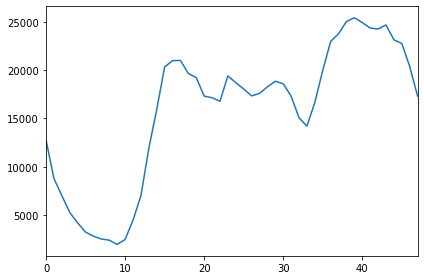

In [8]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.show_at(0)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.289868,0.168801,00:02
1,0.183720,0.108955,00:02
2,0.132761,0.085061,00:02
3,0.100394,0.072431,00:02
4,0.083776,0.074868,00:02
5,0.072957,0.062852,00:02
6,0.065539,0.052166,00:02
7,0.057544,0.046130,00:02
8,0.052890,0.040745,00:02
9,0.047313,0.048109,00:02



epochs: 50 best epoch:  47  val_loss: 0.010113 - pretrained weights_path='models/encoder_MVP.pth'



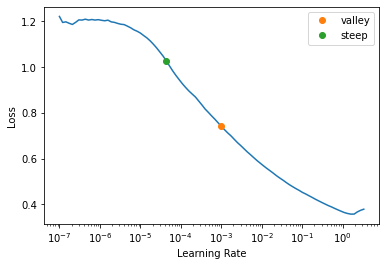

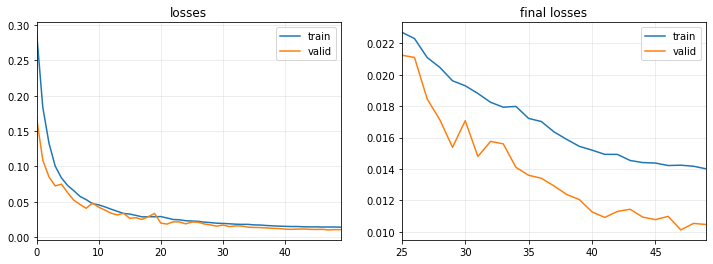

In [9]:
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs=[WandbCallback(log_preds=False),
                        MVP(r = 0.5, target_dir='./models', fname=f'encoder_MVP')])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=50, lr_max=lr_valley)
learn.plot_metrics()

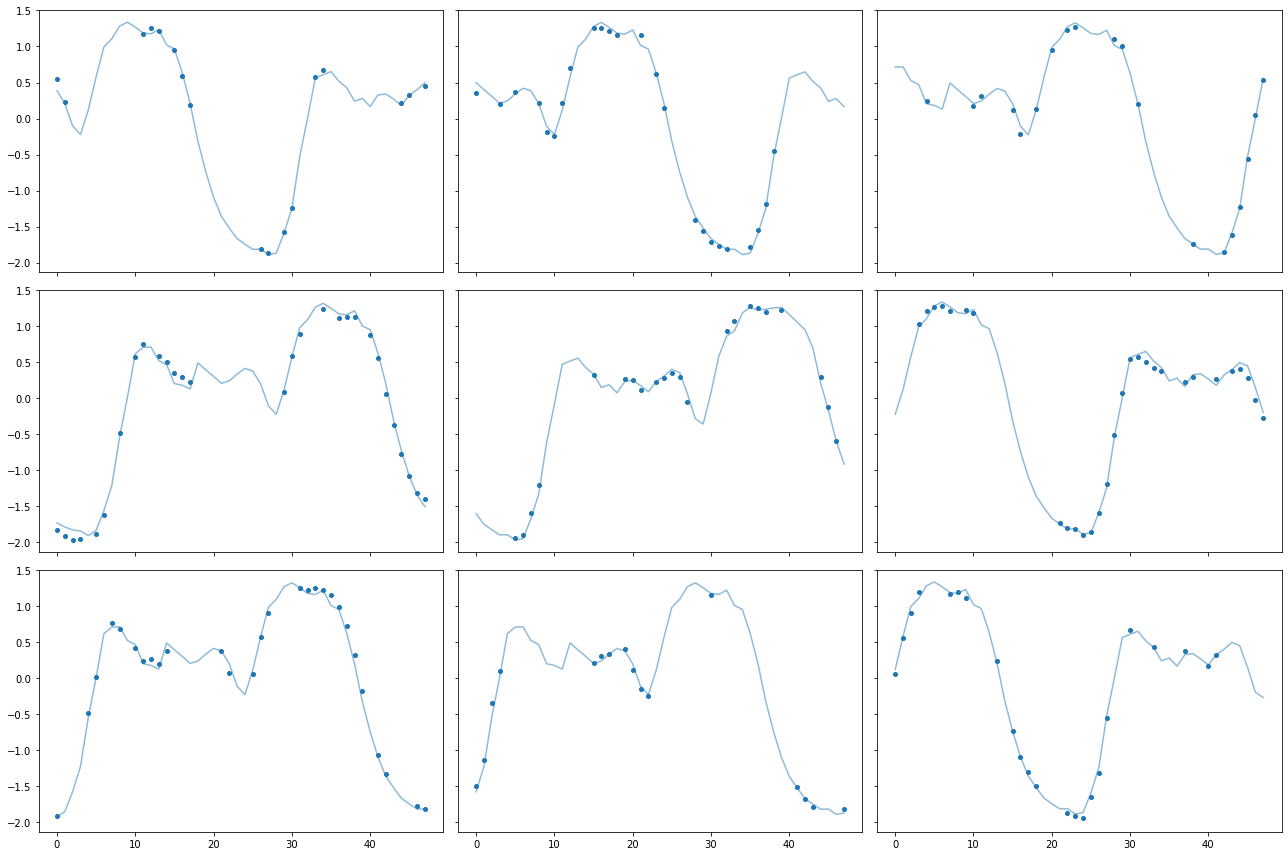

In [10]:
learn.MVP.show_preds(sharey=True)

In [11]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: run.log_artifact(ReferenceArtifact(aux_learn, f'mvp', type='learner', metadata=dict(run.config)), 
                                      aliases=f'run-{run.project}-{run.id}')

In [12]:
run.finish()

epoch,50
train_loss,0.01401
raw_loss,0.01134
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
